pip临时换清华源：
pip install opencv-python -i https://pypi.tuna.tsinghua.edu.cn/simple/

In [1]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm, tqdm_notebook

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

# 步骤1：定义好读取图像的Dataset
The Street View House Numbers (SVHN) Dataset

In [2]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 设置最长的字符长度为5个
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (5 - len(lbl)) * [10]
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

# 步骤2：定义训练数据和验证数据的Dataset

(350, 741, 3)


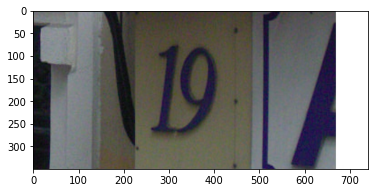

In [3]:
# 预览一下原始数据
from matplotlib import pyplot 
%matplotlib inline
import imageio
img_arr = imageio.imread('../input/train/000000.png') 
print(img_arr.shape)
img = torch.from_numpy(img_arr) 
pyplot.imshow(img)

In [4]:
train_path = glob.glob('../input/train/*.png')
train_path.sort()
train_json = json.load(open('../input/train.json'))
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path), len(train_label))

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),
                    transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=True, 
    #num_workers=10,
)

val_path = glob.glob('../input/val/*.png')
val_path.sort()
val_json = json.load(open('../input/val.json'))
val_label = [val_json[x]['label'] for x in val_json]
print(len(val_path), len(val_label))

val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=10,
)

30000 30000
10000 10000


# 步骤3：定义好字符分类模型，使用renset18的模型作为特征提取模块
renset18: 18指定的是带有权重的 18层，包括卷积层和全连接层，不包括池化层和BN层。参考：https://www.jianshu.com/p/085f4c8256f1

In [5]:
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
                
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

# 步骤4：定义好训练、验证和预测模块

In [6]:
def train(train_loader, model, criterion, optimizer):
    # 切换模型为训练模式
    model.train()
    train_loss = []
    
    for i, (input, target) in enumerate(train_loader):
        if use_cuda:
            input = input.cuda()
            target = target.cuda()
            
        c0, c1, c2, c3, c4 = model(input)
        target = target.long()
        loss = criterion(c0, target[:, 0]) + \
                criterion(c1, target[:, 1]) + \
                criterion(c2, target[:, 2]) + \
                criterion(c3, target[:, 3]) + \
                criterion(c4, target[:, 4])
        
        # loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(loss.item())
        
        train_loss.append(loss.item())
    return np.mean(train_loss)

def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if use_cuda:
                input = input.cuda()
                target = target.cuda()
            
            c0, c1, c2, c3, c4 = model(input)
            target = target.long()
            loss = criterion(c0, target[:, 0]) + \
                    criterion(c1, target[:, 1]) + \
                    criterion(c2, target[:, 2]) + \
                    criterion(c3, target[:, 3]) + \
                    criterion(c4, target[:, 4])
            # loss /= 6
            val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    
    # TTA 次数
    for _ in range(tta):
        test_pred = []
    
        with torch.no_grad():
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()
                
                c0, c1, c2, c3, c4 = model(input)
                
                output = np.concatenate([
                    c0.data.numpy(), 
                    c1.data.numpy(),
                    c2.data.numpy(), 
                    c3.data.numpy(),
                    c4.data.numpy()], axis=1)
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

# 步骤5：迭代训练和验证模型
conda install -c conda-forge ipywidgets

In [ ]:
model = SVHN_Model1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

use_cuda = None
if use_cuda:
    model = model.cuda()

for epoch in range(2):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss = validate(val_loader, model, criterion)
    
    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict(val_loader, model, 1)
    val_predict_label = np.vstack([
        val_predict_label[:, :11].argmax(1),
        val_predict_label[:, 11:22].argmax(1),
        val_predict_label[:, 22:33].argmax(1),
        val_predict_label[:, 33:44].argmax(1),
        val_predict_label[:, 44:55].argmax(1),
    ]).T
    val_label_pred = []
    for x in val_predict_label:
        val_label_pred.append(''.join(map(str, x[x!=10])))
    
    val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, train_loss, val_loss))
    print(val_char_acc)
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')

14.457610130310059
4.142891883850098
3.3269457817077637
3.5147948265075684
3.376272678375244
2.5758299827575684
2.276838779449463
2.6857998371124268


# 步骤6：对测试集样本进行预测，生成提交文件     

In [ ]:
test_path = glob.glob('../input/test_a/*.png')
test_path.sort()
test_label = [[1]] * len(test_path)
print(len(val_path), len(val_label))

test_loader = torch.utils.data.DataLoader(
    SVHNDataset(test_path, test_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    #num_workers=10,
)

test_predict_label = predict(test_loader, model, 1)

test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
test_predict_label = np.vstack([
    test_predict_label[:, :11].argmax(1),
    test_predict_label[:, 11:22].argmax(1),
    test_predict_label[:, 22:33].argmax(1),
    test_predict_label[:, 33:44].argmax(1),
    test_predict_label[:, 44:55].argmax(1),
]).T

test_label_pred = []
for x in test_predict_label:
    test_label_pred.append(''.join(map(str, x[x!=10])))
    
import pandas as pd
df_submit = pd.read_csv('../input/test_A_sample_submit.csv')
df_submit['file_code'] = test_label_pred
df_submit.to_csv('renset18.csv', index=None)

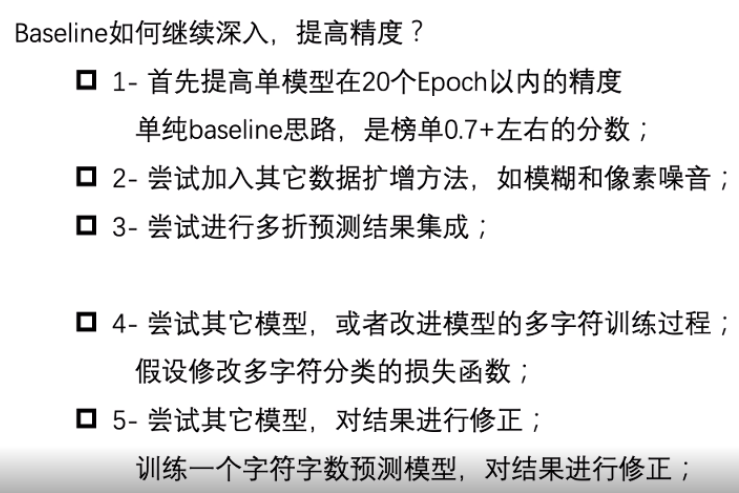

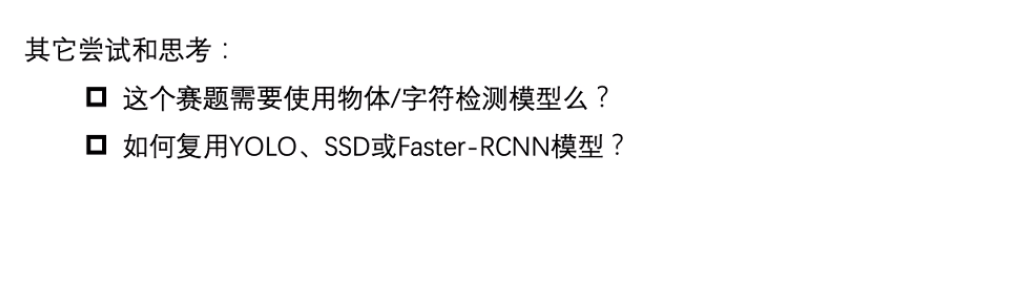